In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Reshape, LeakyReLU, BatchNormalization



## Load Data

In [3]:
# Load the data into pandas dataframes
test_images_df = pd.read_csv('csvTestImages 10k x 784.csv')
test_labels_df = pd.read_csv('csvTestLabel 10k x 1.csv')
train_images_df = pd.read_csv('csvTrainImages 60k x 784.csv')
train_labels_df = pd.read_csv('csvTrainLabel 60k x 1.csv')

In [4]:
# Convert dataframes to numpy arrays
test_images_array = test_images_df.values
test_labels_array = test_labels_df.values
train_images_array = train_images_df.values
train_labels_array = train_labels_df.values

train_images_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [5]:
# Print the shapes of each dataframe and array
print(f"Shape of test images dataframe: {test_images_df.shape}")
print(f"Shape of test labels dataframe: {test_labels_df.shape}")
print(f"Shape of train images dataframe: {train_images_df.shape}")
print(f"Shape of train labels dataframe: {train_labels_df.shape}")

print(f"Shape of test images array: {test_images_array.shape}")
print(f"Shape of test labels array: {test_labels_array.shape}")
print(f"Shape of train images array: {train_images_array.shape}")
print(f"Shape of train labels array: {train_labels_array.shape}")


Shape of test images dataframe: (9999, 784)
Shape of test labels dataframe: (9999, 1)
Shape of train images dataframe: (59999, 784)
Shape of train labels dataframe: (59999, 1)
Shape of test images array: (9999, 784)
Shape of test labels array: (9999, 1)
Shape of train images array: (59999, 784)
Shape of train labels array: (59999, 1)


## Normalize the image data, Viusalize and Reshape

In [6]:
# Normalize the image data by dividing by 255
train_images_array = train_images_df.values / 255.0
test_images_array = test_images_df.values / 255.0

# Reshape the arrays to 28 x 28
train_images_reshaped = train_images_array.reshape(-1, 28, 28)
test_images_reshaped = test_images_array.reshape(-1, 28, 28)

# Print the new shapes
print(f"Shape of normalized and reshaped train images: {train_images_reshaped.shape}")
print(f"Shape of normalized and reshaped test images: {test_images_reshaped.shape}")


Shape of normalized and reshaped train images: (59999, 28, 28)
Shape of normalized and reshaped test images: (9999, 28, 28)


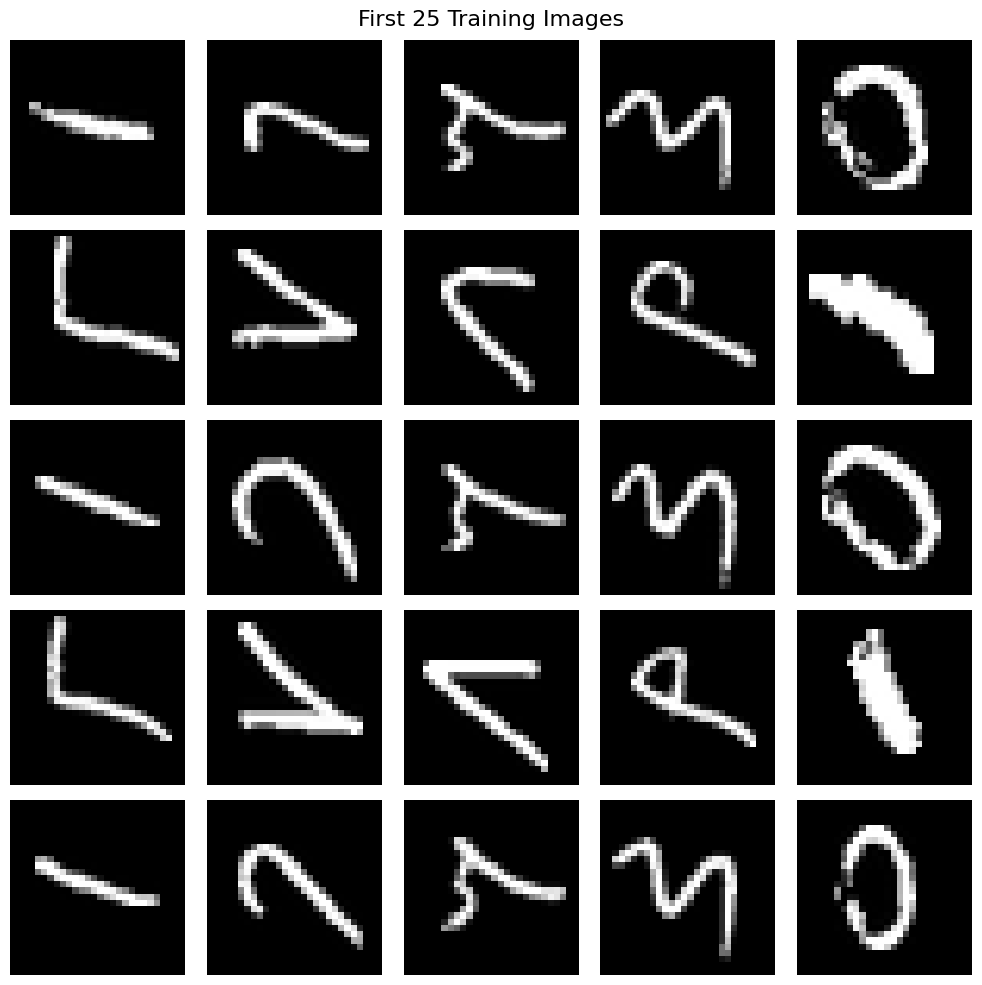

In [7]:
# Visualize the first 25 training images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images_reshaped[i], cmap='gray')  # Display the image in grayscale
    plt.axis('off')  # Hide axis for better visualization
plt.suptitle("First 25 Training Images", fontsize=16)
plt.tight_layout()
plt.show()


In [8]:
# Load label dataframes
train_labels_array = train_labels_df.values
test_labels_array = test_labels_df.values

# Reshape the labels into 2D arrays
train_labels_reshaped = train_labels_array.reshape(-1, 1)
test_labels_reshaped = test_labels_array.reshape(-1, 1)

# Print the shapes of the reshaped labels
print(f"Shape of reshaped train labels: {train_labels_reshaped.shape}")
print(f"Shape of reshaped test labels: {test_labels_reshaped.shape}")


Shape of reshaped train labels: (59999, 1)
Shape of reshaped test labels: (9999, 1)


## Function to Generate Real Samples

In [10]:
def generate_real_samples(data, labels, n_samples):
    """
    Generate a batch of real samples from the dataset.
    Args:
        data: The dataset (numpy array of images).
        labels: The corresponding labels (numpy array).
        n_samples: Number of samples to generate.
    Returns:
        A tuple of real images, their labels, and a corresponding array of 1s (real class).
    """
    # Randomly choose indices for the samples
    indices = np.random.randint(0, data.shape[0], n_samples)
    X = data[indices]  # Select images
    y = labels[indices]  # Select labels
    # Return images, labels, and an array of 1s
    return X, y, np.ones((n_samples, 1))


## Function to Generate Fake Inputs

In [11]:
def generate_latent_points(latent_dim, n_samples):
    """
    Generate input for the generator (latent space points).
    Args:
        latent_dim: Dimensionality of the latent space.
        n_samples: Number of latent points to generate.
    Returns:
        Latent points array of shape (n_samples, latent_dim).
    """
    return np.random.randn(n_samples, latent_dim)


## Define and Compile the Generator Model

In [15]:
def define_generator(latent_dim):
    model = Sequential()
    # Fully connected layer to upscale latent input to match Reshape target
    model.add(Dense(128 * 14 * 14, activation='relu', input_dim=latent_dim))
    print(f"Shape after Dense: {128 * 14 * 14}")  # Debugging total size
    model.add(Reshape((14, 14, 128)))  # Correct shape
    print(f"Shape after Reshape: {14, 14, 128}")  # Debugging shape
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    return model


latent_dim = 100
generator = define_generator(latent_dim)
generator.summary()

Shape after Dense: 25088
Shape after Reshape: (14, 14, 128)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 25088)             2533888   
                                                                 
 reshape_6 (Reshape)         (None, 14, 14, 128)       0         
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
Total params: 2534400 (9.67 MB)
Trainable params: 2534144 (9.67 MB)
Non-trainable params: 256 (1.00 KB)
_________________________________________________________________


## Generate Fake Sample

In [16]:
import numpy as np

def generate_fake_samples(generator, latent_dim, n_samples):
    """
    Generates fake samples using the generator model.

    Args:
    - generator: The trained generator model.
    - latent_dim: Dimension of the latent space.
    - n_samples: Number of fake samples to generate.

    Returns:
    - X: Generated fake samples.
    - y: Labels for the fake samples (all zeros, since they are fake).
    """
    # Generate random noise as input for the generator
    noise = np.random.randn(n_samples, latent_dim)
    
    # Generate fake samples
    X = generator.predict(noise)
    
    # Create 'fake' labels (0)
    y = np.zeros((n_samples, 1))
    
    return X, y


## Define and compile a Discrimator Model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam

def define_discriminator(input_shape):
    """
    Defines and compiles a discriminator model.
    
    Args:
    - input_shape: Shape of the input images (e.g., (28, 28, 1) for grayscale images).
    
    Returns:
    - model: Compiled discriminator model.
    """
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Flatten and fully connected layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Output: probability of real (1) or fake (0)
    
    # Compile the model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


input_shape = (28, 28, 1) 

# Discrimator Sunnary
discriminator = define_discriminator(input_shape)
discriminator.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

##  Compile and define GAN model

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

def define_generator(latent_dim):
    """
    Defines a generator model.

    Args:
    - latent_dim: Dimension of the latent space.

    Returns:
    - model: Generator model.
    """
    model = Sequential()

    # Dense layer to project latent_dim into a higher-dimensional space
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))  # Reshape into a 7x7x128 tensor

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 28x28
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Output layer: Upsample to 28x28x1 with tanh activation
    model.add(Conv2DTranspose(1, (7, 7), activation='tanh', padding='same'))

    return model

# Print Generator summary 
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                                                      
                                                                 
 batch_normalization_6 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)      

In [21]:
# GAN Summary
gan = define_gan(generator, discriminator)
gan.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_6 (Sequential)   (None, 28, 28, 1)         1030785   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 80769     
                                                                 
Total params: 1111554 (4.24 MB)
Trainable params: 1030401 (3.93 MB)
Non-trainable params: 81153 (317.00 KB)
_________________________________________________________________


## Conclusion

1/1 [==============================] - 1s 636ms/step


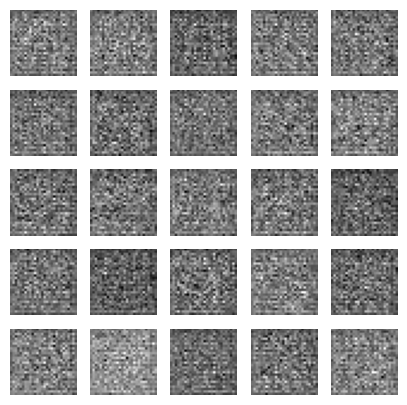

In [22]:
# Function to generate and display fake images
def generate_fake_images(generator, latent_dim, num_images=25):
    # Generate random latent vectors
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    
    # Generate fake images using the generator model
    fake_images = generator.predict(noise)
    
    # Plot the images in a 5x5 grid
    plt.figure(figsize=(5, 5))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(fake_images[i, :, :, 0], cmap='gray')  # Assuming grayscale images
        plt.axis('off')
    
    plt.show()

# Example of generating fake images
generate_fake_images(generator, latent_dim=100)
